In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/train.csv", index_col=0)

In [3]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df.shape

(10933, 2)

In [5]:
df.label.value_counts()

positive    6383
negative    3412
neutral     1138
Name: label, dtype: int64

In [6]:
import re

def cleansing(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text).strip()    
    
    return text

df["text_clean"] = df.text.apply(cleansing)

df.text_clean

0        warung ini dimiliki oleh pengusaha pabrik tahu...
1        mohon ulama lurus dan k212 mmbri hujjah partai...
2        lokasi strategis di jalan sumatera bandung tem...
3        betapa bahagia nya diri ini saat unboxing pake...
4        duh jadi mahasiswa jangan sombong dong kasih k...
                               ...                        
10993    f demokrat dorong upaya kemandirian energi nas...
10994                                          tidak bosan
10996    enak rasa masakan nya apalagi kepiting yang me...
10998    pagi pagi di tol pasteur sudah macet parah bik...
10999    meskipun sering belanja ke yogya di riau junct...
Name: text_clean, Length: 10933, dtype: object

In [7]:
neg = df.loc[df["label"] == "negative"].text_clean.to_list()
neu = df.loc[df["label"] == "neutral"].text_clean.to_list()
pos = df.loc[df["label"] == "positive"].text_clean.to_list()

neg_label = df.loc[df["label"] == "negative"].label.to_list()
neu_label = df.loc[df["label"] == "neutral"].label.to_list()
pos_label = df.loc[df["label"] == "positive"].label.to_list()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


In [8]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=" ", lower=True)
tokenizer.fit_on_texts(total_data)

with open("../lstm/tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created")
    
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open("../lstm/x_pad_sequences.pickle", "wb") as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created")

tokenizer.pickle has created
x_pad_sequences.pickle has created


In [9]:
Y = pd.get_dummies(labels)
Y = Y.values

with open("../lstm/y_labels.pickle", "wb") as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created")

y_labels.pickle has created


In [10]:
from sklearn.model_selection import train_test_split

file = open("../lstm/x_pad_sequences.pickle", "rb")
X = pickle.load(file)
file.close()

file = open("../lstm/y_labels.pickle", "rb")
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [11]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation="softmax"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
875/875 [==============================] - 202s 225ms/step - loss: 0.4558 - accuracy: 0.8179 - val_loss: 0.3688 - val_accuracy: 0.8697
Epoch 2/10
875/875 [==============================] - 202s 231ms/step - loss: 0.1950 - accuracy: 0.9282 - val_loss: 0.3319 - val_accuracy: 0.8820
Epoch 3/10


In [12]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 3s 27ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       668
           1       0.82      0.76      0.79       231
           2       0.91      0.92      0.92      1288

    accuracy                           0.87      2187
   macro avg       0.85      0.83      0.84      2187
weighted avg       0.87      0.87      0.87      2187



In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.utils import to_categorical

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []
y = to_categorical(np.array(Y)[:len(X)])
embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):
    
    data_train = X[data[0]]
    target_train = y[data[0]]
    
    data_test = X[data[1]]
    target_test = y[data[1]]
    
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3, activation="softmax"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    
    es = EarlyStopping(monitor="val_loss", mode="min", verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])
    
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    
    print("Training ke-", iteration)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print("======================================================")
    
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata accuracy:", average_accuracy)

69/69 [==============================] - 3s 28ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       668
           1       0.88      0.75      0.81       231
           2       0.94      0.92      0.93      1288

    accuracy                           0.89      2187
   macro avg       0.88      0.85      0.86      2187
weighted avg       0.89      0.89      0.89      2187

69/69 [==============================] - 3s 28ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       668
           1       0.85      0.73      0.79       231
           2       0.88      0.95      0.91      1288

    accuracy                           0.87      2187
   macro avg       0.86      0.81      0.83      2187
weighted avg       0.87      0.87      0.87      2187

69/69 [==============================] - 3s 26ms/step
Training ke- 3
              precision    reca

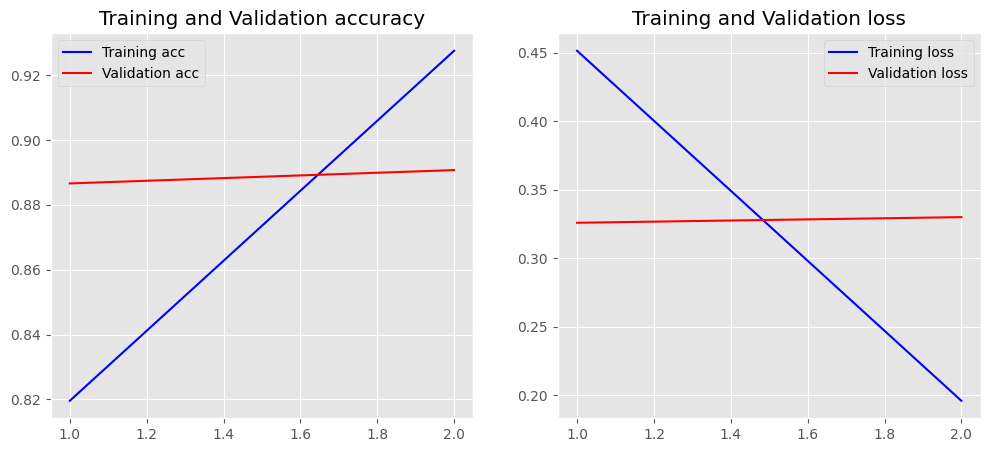

In [14]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and Validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and Validation loss")
    plt.legend()
    
%matplotlib inline
plot_history(history)

In [15]:
model.save("../lstm/model.h5")
print("Model has created")

Model has created


In [18]:
from keras.models import load_model

def cleansing(text):
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    return text

prompt = "sedih banget."

sentiment = ["negative", "neutral", "positive"]

text = [cleansing(prompt)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model("../lstm/model.h5")
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text:", text[0])
print("Sentiment:", sentiment[polarity])

1/1 [==============================] - 1s 968ms/step
Text: sedih banget 
Sentiment: negative
